<a href="https://colab.research.google.com/github/vincenzomanzoni/pytorch-forecasting-examples/blob/main/01_Pytorch_Forecasting_Example_NBeats.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Pytorch Forecasting | N-Beats

## Install Pytorch Forecasting and import libraries

In [ ]:
!pip install pytorch-forecasting

In [41]:
import pandas as pd
import matplotlib.pyplot as plt
import torch

import pytorch_lightning as pl
from pytorch_lightning.callbacks import EarlyStopping

from pytorch_forecasting import TimeSeriesDataSet, Baseline, NBeats
from pytorch_forecasting.data.examples import generate_ar_data
from pytorch_forecasting.metrics import SMAPE

## Dataset generation

In [2]:
data = generate_ar_data(seasonality=12, timesteps=364, n_series=1, seed=42, trend = 3.0, noise = 0.2)

In [3]:
data.head()

,series,time_idx,value
0,0,0,0.000000
1,0,1,0.199311
2,0,2,0.538868
3,0,3,0.683969
4,0,4,0.681237


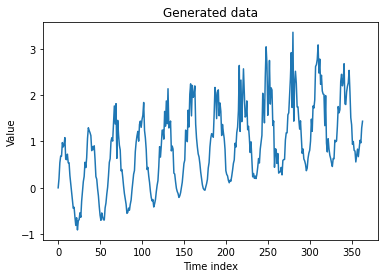

In [4]:
plt.plot(data.time_idx, data.value)
plt.title('Generated data')
plt.xlabel('Time index')
plt.ylabel('Value')
plt.show()

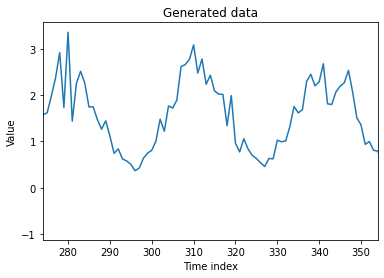

In [5]:
plt.plot(data.value)
plt.xlim(354-80, 354)
plt.title('Generated data')
plt.xlabel('Time index')
plt.ylabel('Value')
plt.show()

## Creation of datasets and dataloaders

In [23]:
# Create dataset and dataloaders
max_encoder_length = 60
max_prediction_length = 20
batch_size = 16

training_cutoff = data["time_idx"].max() - max_prediction_length

context_length = max_encoder_length
prediction_length = max_prediction_length

training = TimeSeriesDataSet(
    data[lambda x: x.time_idx <= training_cutoff],
    time_idx="time_idx",
    target="value",
    group_ids=["series"],
    time_varying_unknown_reals=["value"],    
    max_encoder_length=context_length,
    max_prediction_length=prediction_length,    
)
validation = TimeSeriesDataSet.from_dataset(training, data, min_prediction_idx=training_cutoff + 1)

train_dataloader = training.to_dataloader(train=True, batch_size=batch_size, num_workers=0)
val_dataloader = validation.to_dataloader(train=False, batch_size=batch_size, num_workers=0)

## Calculate Baseline Error

In [24]:
actuals = torch.cat([y[0] for x, y in iter(val_dataloader)])
baseline_predictions = Baseline().predict(val_dataloader)
SMAPE()(baseline_predictions, actuals)

tensor(0.5114)

## Train NBeats

In [61]:
pl.seed_everything(42)

early_stop_callback = EarlyStopping(monitor="val_loss", min_delta=1e-4, patience=10, verbose=False, mode="min")
trainer = pl.Trainer(
    max_epochs=100,
    gpus=1,
    weights_summary="top",
    gradient_clip_val=0.1,
    callbacks=[early_stop_callback],
    limit_train_batches=30,
)

net = NBeats.from_dataset(
    training,
    learning_rate=0.1,
    #log_interval=10,
    #log_val_interval=1,
    weight_decay=1e-2,
    widths=[32, 512],
    backcast_loss_ratio=1.0,
)

#trainer = pl.Trainer(gpus=1, gradient_clip_val=0.1)
#net = NBeats.from_dataset(training, learning_rate=0.01, weight_decay=1e-2, widths=[32, 512], backcast_loss_ratio=0.1)

Global seed set to 42
/usr/local/lib/python3.6/dist-packages/pytorch_lightning/utilities/distributed.py:50: UserWarning: You have set progress_bar_refresh_rate < 20 on Google Colab. This may crash. Consider using progress_bar_refresh_rate >= 20 in Trainer.
  warnings.warn(*args, **kwargs)
GPU available: True, used: True
TPU available: None, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


## Find Optimal Learning Rate


  | Name            | Type       | Params
-----------------------------------------------
0 | loss            | MASE       | 0     
1 | logging_metrics | ModuleList | 0     
2 | net_blocks      | ModuleList | 1.7 M 
-----------------------------------------------
1.7 M     Trainable params
0         Non-trainable params
1.7 M     Total params


LR finder stopped early due to diverging loss.
Restored states from the checkpoint file at /content/lr_find_temp_model.ckpt



suggested learning rate: 0.0025118864315095794


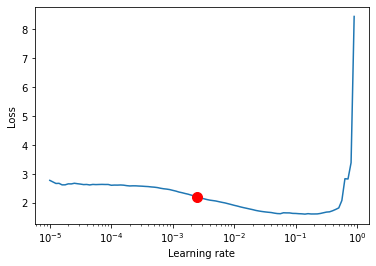

In [51]:
res = trainer.tuner.lr_find(net, train_dataloader=train_dataloader, val_dataloaders=val_dataloader, min_lr=1e-5)
print(f"suggested learning rate: {res.suggestion()}")
fig = res.plot(show=True, suggest=True)
fig.show()


In [62]:
# Look at the above char and put here the learning rate which corresponds
# to the minimum of the function. Usually, 0.01 is a good choice.
net.hparams.learning_rate = 0.01
net.hparams.log_interval = 10
net.hparams.log_val_interval = 1

In [ ]:
early_stop_callback = EarlyStopping(monitor="val_loss", min_delta=1e-4, patience=10, verbose=False, mode="min")
trainer = pl.Trainer(
    max_epochs=100,
    gpus=1,
    weights_summary="top",
    gradient_clip_val=0.01,
    callbacks=[early_stop_callback],
    limit_train_batches=30,
)

net = NBeats.from_dataset(
    training,
    learning_rate=0.1,
    log_interval=10,
    log_val_interval=1,
    weight_decay=1e-2,
    widths=[32, 512],
    backcast_loss_ratio=1.0,
)

In [63]:
trainer.fit(
    net,
    train_dataloader=train_dataloader,
    val_dataloaders=val_dataloader,
)


  | Name            | Type       | Params
-----------------------------------------------
0 | loss            | MASE       | 0     
1 | logging_metrics | ModuleList | 0     
2 | net_blocks      | ModuleList | 1.7 M 
-----------------------------------------------
1.7 M     Trainable params
0         Non-trainable params
1.7 M     Total params


1

## Get the best model

In [64]:
best_model_path = trainer.checkpoint_callback.best_model_path
best_model = NBeats.load_from_checkpoint(best_model_path)

### Compute the MAPE of the best model

In [86]:
actuals = torch.cat([y[0] for x, y in iter(val_dataloader)])
predictions = best_model.predict(val_dataloader)
print("MAE: {0:.3}".format((actuals - predictions).abs().mean().item()))
print("MAPE: {0:.3}%".format((100 * (actuals - predictions) / actuals).abs().mean().item()))

MAE: 0.12
MAPE: 9.69%


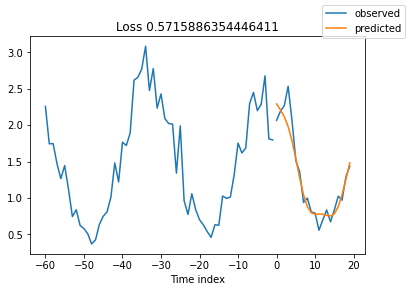

In [88]:
raw_predictions, x = best_model.predict(val_dataloader, mode="raw", return_x=True)
best_model.plot_prediction(x, raw_predictions, add_loss_to_title=True);

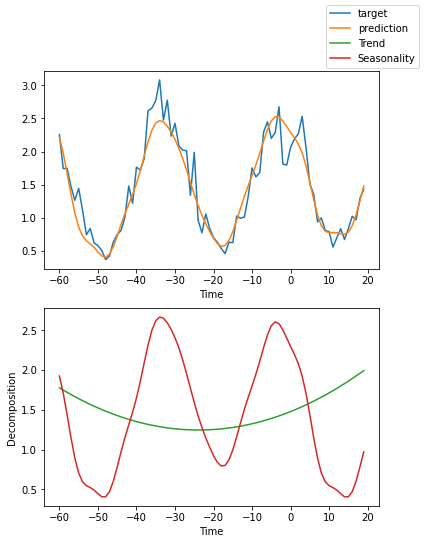

In [91]:
best_model.plot_interpretation(x, raw_predictions, idx=0);